- https://github.com/python-hydro/hydro_examples/blob/master/elliptic/poisson_fft.py
- Page 16 of https://astro.uchicago.edu/~andrey/Talks/PM/pm.pdf
- https://fast-poisson-solver.readthedocs.io/en/latest/

https://physics.stackexchange.com/questions/773566/poisson-equation-in-cosmology-at-first-order-in-perturbation-theory

https://github.com/grkooij/Cosmological-Particle-Mesh-Simulation

See GLAMdoc.pdf for more details.

For f(R):
- https://arxiv.org/pdf/2303.07121.pdf
- Appendix B of https://iopscience.iop.org/article/10.1088/0067-0049/211/2/23

In [28]:
import numpy as np

In [29]:
# import pyfftw

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [31]:
# # Values taken from simulation Setup.dat.
# OMEGA_M = 3.08900E-01
# h = 6.77400E-01

# def G_constant(omega_m, h):
#     H0 = h * 100
#     return 3./2 * omega_m * H0**2

# G = G_constant(OMEGA_M, h)
from astropy.constants import G
G = G.value
# G = 1
a = 1.0  # Scale factor

In [32]:
# ******** SEE https://github.com/grkooij/Cosmological-Particle-Mesh-Simulation/blob/master/src/configure_me.py ********
N_PARTS          = 256 # Number of particles in one dimension
BOX_SIZE         = 128 # Box size in Mpc/h in one dimension
N_CELLS          = 256 # Number of cells in one dimension
N_CPU            = 1 # Number of cpu's used

def get_potential(density):
    """This is for the Newtonian gravity.

    See GLAMdoc.pdf. The approach used in this function is the simples way
    to related matter densities to the gravitational potential. But it may
    not be the most accurate.
    """
    density_mean = density.mean()
    density_contrast = density / density.mean() - 1

    density_k = np.fft.fftn(density_contrast)

    scale = 2*np.pi*N_PARTS/BOX_SIZE
    lxaxis = scale*np.fft.fftfreq(N_PARTS)
    lyaxis = scale*np.fft.fftfreq(N_PARTS)

    #2D Fourier axes
    ly, lx = np.meshgrid(lyaxis, lxaxis, indexing='ij')

    #-k squared operator where k = sqrt(lx**2 + ly**2)
    del_sq = -(lx**2 + ly**2)

    #Calculating potential and correcting for scale with mass resolution
    scaled_density_k = density_k * (4 * np.pi * G * a**2 * density_mean)
    # As mentioned in Page 16 of https://astro.uchicago.edu/~andrey/Talks/PM/pm.pdf,
    # singularity during division is handled by manually setting the potential to zero when |k| = 0.
    # That's why we input the `out` argument.
    potential_k = np.divide(scaled_density_k, del_sq, where=del_sq!=0, out=np.zeros_like(scaled_density_k))

    potential_real = np.fft.ifftn(potential_k).real
    return potential_real

In [33]:
arr = np.load('Run10_3072_1.npy')
potential_gr = get_potential(arr[:,:256])
# TODO: Need to solve the modified Poisson equation for f(R). This implementation solves the GR equation, which is incorrect.
potential_fr = get_potential(arr[:,256:])

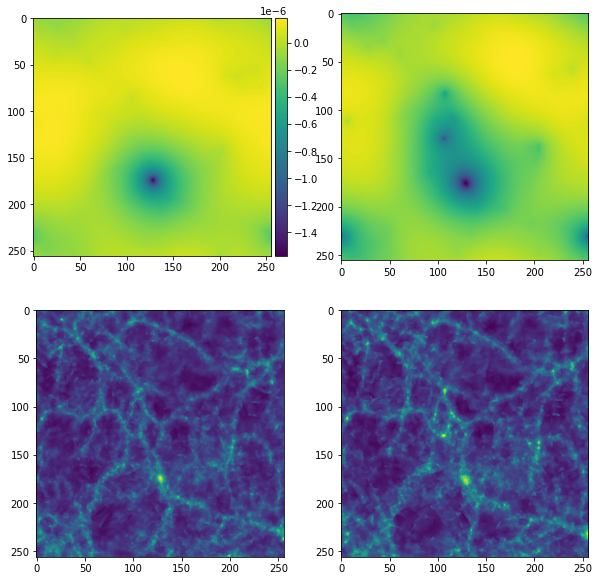

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 1].imshow(potential_fr)  # TODO
ax[1, 0].imshow(np.log10(arr[:,:256]))
ax[1, 1].imshow(np.log10(arr[:,256:]))

divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax[0,0].imshow(potential_gr)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

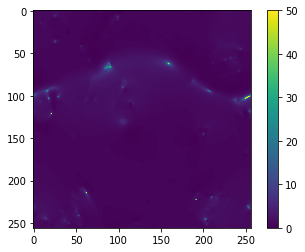

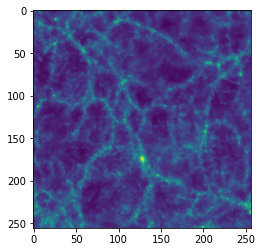

In [35]:
force_gr = np.sqrt(np.gradient(potential_gr, axis=0) ** 2 + np.gradient(potential_gr, axis=1) ** 2)
force_fr = np.sqrt(np.gradient(potential_fr, axis=0) ** 2 + np.gradient(potential_fr, axis=1) ** 2)

ratio = force_fr/force_gr

plt.imshow(ratio, vmin=0, vmax=50); plt.colorbar(); plt.show()
plt.imshow(np.log10(arr[:, :256])); plt.show()

# IN REALITY, F5/FN must be maximum of 0.33, but this may not hold because we are using an approximated version.

In [36]:
ratio.min(), ratio.max()

(0.008561027348556023, 137.94286429068083)

In [37]:
ratio < np.quantile(ratio, 0.999)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [38]:
arr = np.load('Run2_3061_1.npy')
gr = arr[:, :256].copy()
fr = arr[:, 256:].copy()

mask = ratio < np.quantile(ratio, 0.5)

fr[mask] = gr[mask]

In [39]:
np.all(fr == arr[:,256:])

False

In [40]:
mask.shape, fr.shape, gr.shape

((256, 256), (256, 256), (256, 256))

In [41]:
gr[mask].shape

(32768,)

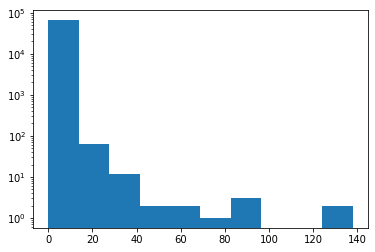

In [42]:
plt.hist(ratio.flatten()); plt.yscale('log')

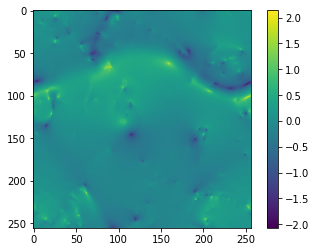

In [43]:
plt.imshow(np.log10(ratio)); plt.colorbar()

(0.0, 10.0)

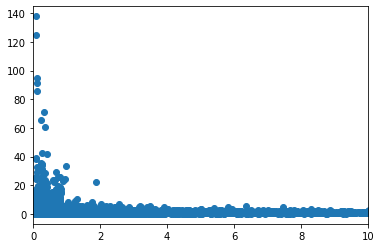

In [44]:
plt.scatter((gr/gr.mean()).flatten(), ratio.flatten())
plt.xlim([0, 10])

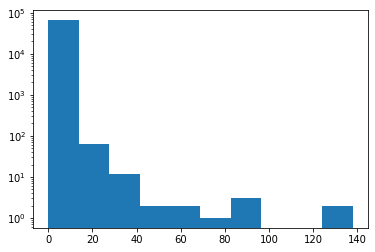

In [45]:
plt.hist(ratio.flatten()); plt.yscale('log')

In [46]:
np.quantile(ratio, 0.999), np.quantile(ratio, 0.99), np.quantile(ratio, 0.75), np.quantile(ratio, 0.5)

(16.09384671401687, 5.176194344954257, 1.387865808343974, 0.8602575239120767)

### ABOVE THIS, THE CODE IS RELIABLE

In [12]:
# def check_fr_potential_and_gr_potential(gr_potential, fr_potential, f_R):
#     assert np.all(fr_potential == gr_potential - 0.5 * f_R)  # f_R is the scalar field.

In [13]:
# from scipy.ndimage import convolve

# def laplacian_of_potential(phi):
#     laplacian_x = np.gradient(np.gradient(phi, axis=0), axis=0)  # Second derivative with respect to x
#     laplacian_y = np.gradient(np.gradient(phi, axis=1), axis=1)  # Second derivative with respect to y
#     laplacian = laplacian_x + laplacian_y  # Total Laplacian

#     # import cv2
#     # laplacian = cv2.Laplacian(phi, cv2.CV_64F, ksize=5)

#     return laplacian

# dx, dy = BOX_SIZE/N_CELLS, BOX_SIZE/N_CELLS
# x = laplacian_of_potential(potential_gr) - (16/3) * np.pi * G * a**2 * (arr[:, :256]-arr[:, :256].mean())
# delta_R = 6 * x / (a**2)
# plt.imshow(delta_R); plt.colorbar()

In [14]:
# plt.imshow(laplacian_of_potential(potential_gr)); plt.colorbar()

In [15]:
# plt.hist(delta_R.flatten()); plt.yscale('log')

In [16]:
# def laplacian_of_potential(phi, dx, dy):
#     # Calculate the Laplacian of the potential phi
#     d2phi_dx2 = np.gradient(np.gradient(phi, axis=0), axis=0) / dx**2
#     d2phi_dy2 = np.gradient(np.gradient(phi, axis=1), axis=1) / dy**2

#     # Sum the second derivatives to obtain the Laplacian
#     laplacian_result = d2phi_dx2 + d2phi_dy2

#     return laplacian_result

# from scipy.signal import convolve2d

# def apply_2d_laplacian(grid, dx, dy):
#     """
#     Apply a 2D Laplacian operator to a 2D grid using finite differences.

#     Parameters:
#     - grid: 2D numpy array representing the input grid.
#     - dx: Grid spacing in the x-direction.
#     - dy: Grid spacing in the y-direction.

#     Returns:
#     - laplacian_result: 2D numpy array containing the result of the Laplacian operator.
#     """

#     # Calculate the finite difference coefficients
#     alpha = 1 / dx**2
#     beta = 1 / dy**2

#     # Define a 3x3 Laplacian kernel with finite differences
#     laplacian_kernel = np.array([[0, beta, 0], [beta, -2 * (alpha + beta), beta], [0, beta, 0]])

#     # Apply the Laplacian operator using convolution
#     laplacian_result = convolve2d(grid, laplacian_kernel, mode='same', boundary='symm')

#     return laplacian_result

# # Example usage for a 2D array potential
# # Assuming you have a 2D potential array 'phi' with spacing dx and dy
# # Call the function to calculate the Laplacian
# laplacian_result = apply_2d_laplacian(grp, dx, dx)

# laplacian_result[laplacian_result>np.quantile(laplacian_result, 0.99)]=np.quantile(laplacian_result,0.99)
# laplacian_result[laplacian_result<np.quantile(laplacian_result, 0.01)]=np.quantile(laplacian_result,0.01)

# plt.imshow(laplacian_result)

In [17]:
# def get_delta_R(laplacian_result, rho):
#     x = laplacian_result - (16 / 3) * np.pi * G * a**2 * (rho - rho.mean())
#     return (6 * x) / (a**2)

# delta_R = get_delta_R(laplacian_result, arr[:, :256])

In [18]:
# delta_R.shape

In [19]:
# def scalar_field_draft(delta_R, rho):
#     return (-1/3) * a**2 * (delta_R + 8 * np.pi * G * (rho - rho.mean()))

# scalar_field_draft_field = scalar_field_draft(delta_R, arr[:, :256])

# from scipy.sparse import diags
# # from scipy.sparse.linalg import cg
# from scipy.linalg import solve

# def invert_2d_laplacian(laplacian_result, dx, dy):
#     """
#     Invert the operation of a 2D Laplacian operator applied to a grid.

#     Parameters:
#     - laplacian_result: 2D numpy array containing the Laplacian result.
#     - dx: Grid spacing in the x-direction.
#     - dy: Grid spacing in the y-direction.

#     Returns:
#     - inverted_result: 2D numpy array containing the inverted result.
#     """

#     # Calculate the finite difference coefficients
#     alpha = 1 / dx**2
#     beta = 1 / dy**2

#     # Construct the Laplacian matrix
#     N = laplacian_result.shape[0]
#     laplacian_matrix = -2 * (alpha + beta) * np.eye(N) + beta * (np.eye(N, k=1) + np.eye(N, k=-1))

#     # Ensure laplacian_result is flattened
#     flat_laplacian_result = laplacian_result

#     # Invert the Laplacian matrix using scipy.linalg.solve
#     inverted_result = solve(laplacian_matrix, flat_laplacian_result)

#     return inverted_result.reshape((N, N))


# # Call the function to invert the Laplacian
# scalar_field = invert_2d_laplacian(scalar_field_draft_field, dx, dx)

In [20]:
# plt.figure(figsize=(10, 10)); plt.imshow(scalar_field); plt.colorbar(); plt.show()

In [21]:
# scalar_field.shape

In [22]:
# plt.imshow(np.log10(arr[:, :256]))